In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [75]:
# Problem data.
m = 4
n_values = np.arange(start=100, stop=1001, step=100)
b = np.ones(m)

In [3]:
# Number of times to solve the dual equation.
num_dual_samples = 100

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

In [5]:
coin_flips = np.random.randint(2, size=5)

In [84]:
arr*

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.]])

In [50]:
coin_flips

array([1, 0, 2, 0, 3])

In [61]:
np.array([np.arange(m)[:,None], coin_flips[:,None]])

array([array([[0],
       [1],
       [2],
       [3]]),
       array([[1],
       [0],
       [2],
       [0],
       [3]])], dtype=object)

In [69]:
arr = np.zeros((4,5))
coin_flips = np.random.randint(4, size=5)
arr[coin_flips, np.arange(5)] = 1

In [70]:
arr

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.]])

In [66]:
coin_flips

array([1, 0, 2, 0, 3])

In [19]:

    coin_flips = np.random.randint(100, size=num_stoc_samples)

In [20]:
coin_flips

array([52, 50, 31, ...,  1, 91, 10])

# Solve for the stochastic program

In [97]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    #coin_flip = np.random.choice([1, 0], p=[.5, .5])
    #A = np.full((m, num_stoc_samples), coin_flip)
    #coin_flips = np.random.randint(100, size=num_stoc_samples)
    #A = np.tile(coin_flips, m).reshape((m,num_stoc_samples))
    #A = np.zeros((m, num_stoc_samples))
    #A[0] = coin_flips
    #A[1] = 1-coin_flips
    
    A = np.zeros((m, num_stoc_samples))
    coin_flips = np.random.randint(m-1, size=num_stoc_samples)
    A[coin_flips, np.arange(num_stoc_samples)] = 1

    pi = np.random.uniform(0, 1, num_stoc_samples)
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()#verbose=True)
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results

With n=100, iteration completed in 1.26 s
[9.69567723e-01 9.71341578e-01 9.71314569e-01 4.80674844e-14]

With n=200, iteration completed in 2.29 s
[9.84970713e-01 9.85111612e-01 9.85670025e-01 3.31718554e-13]

With n=300, iteration completed in 3.72 s
[9.89855198e-01 9.89138848e-01 9.90478789e-01 7.82010730e-14]

With n=400, iteration completed in 4.96 s
[9.92801081e-01 9.92135694e-01 9.92950861e-01 7.33686279e-14]

With n=500, iteration completed in 6.42 s
[9.93573956e-01 9.94208815e-01 9.94649547e-01 1.29046579e-13]

With n=600, iteration completed in 8.40 s
[9.94949973e-01 9.94809833e-01 9.95021188e-01 1.33842375e-13]

With n=700, iteration completed in 9.82 s
[9.95871354e-01 9.95105308e-01 9.95754005e-01 1.73272321e-13]

With n=800, iteration completed in 11.06 s
[9.96276793e-01 9.96350101e-01 9.97292107e-01 3.69862454e-13]

With n=900, iteration completed in 16.00 s
[9.96212478e-01 9.96951257e-01 9.96525713e-01 8.91592753e-13]

With n=1000, iteration co

In [71]:
# helper method to help us confirm whether the
# matrix is positive definite

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

coin_flip = np.random.choice([1, 0], p=[.5, .5])
A = np.full((m, num_stoc_samples), coin_flip)

coin_flips = np.random.randint(2, size=num_stoc_samples)
A = np.tile(coin_flips, m).reshape((m,num_stoc_samples))


coin_flips = np.random.randint(2, size=num_stoc_samples)
#A = np.tile(coin_flips, m).reshape((m,num_stoc_samples))
A = np.zeros((m, num_stoc_samples))
A[0] = coin_flips
A[1] = 1-coin_flips


coin_flips = np.random.randint(100, size=num_stoc_samples)
A = np.tile(coin_flips, m).reshape((m,num_stoc_samples))
    
    
A = np.zeros((4,5))
coin_flips = np.random.randint(4, size=5)
A[coin_flips, np.arange(5)] = 1

is_pos_def(A@np.transpose(A))

False

In [95]:

A = np.zeros((4,20))
coin_flips = np.random.randint(3, size=20)
A[coin_flips, np.arange(20)] = 1

is_pos_def(A@np.transpose(A))

False

In [96]:
A@np.transpose(A)

array([[ 6.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.],
       [ 0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.]])

# Solve for the dual problem for various values of n

In [98]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        
        #coin_flip = np.random.choice([1, 0], p=[.5, .5])
        #A = np.full((m, n), coin_flip)
        #pi = np.random.uniform(0, 10, n)

        #coin_flips = np.random.randint(100, size=n)
        #A = np.tile(coin_flips, m).reshape((m,n))
        pi = np.random.uniform(0, 10, n)
        
        
        #coin_flips = np.random.randint(2, size=n)
        #A = np.tile(coin_flips, m).reshape((m,num_stoc_samples))
        #A = np.zeros((m, n))
        #A[0] = coin_flips
        #A[1] = 1-coin_flips
    
    
    
        A = np.zeros((m, n))
        coin_flips = np.random.randint(m-1, size=n)
        A[coin_flips, np.arange(n)] = 1
    
        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 100
Average of all dual solutions: [9.46310282e+00 9.49764029e+00 9.51637042e+00 3.89152487e-10]
Expectation of L2 norm between p*n and p* is: 218.26
m log m log log n / n for m=4 and n=100 is: 0.08
Constant C is: 2577.348

For n = 200
Average of all dual solutions: [9.77339855e+00 9.77798542e+00 9.76105176e+00 4.07403671e-10]
Expectation of L2 norm between p*n and p* is: 231.63
m log m log log n / n for m=4 and n=200 is: 0.05
Constant C is: 5010.388

For n = 300
Average of all dual solutions: [9.83554855e+00 9.85965915e+00 9.85630382e+00 4.40790082e-10]
Expectation of L2 norm between p*n and p* is: 235.57
m log m log log n / n for m=4 and n=300 is: 0.03
Constant C is: 7319.654

For n = 400
Average of all dual solutions: [9.88680571e+00 9.89296306e+00 9.88507095e+00 4.44848413e-10]
Expectation of L2 norm between p*n and p* is: 237.42
m log m log log n / n for m=4 and n=400 is: 0.02
Constant C is: 9566.062

For n = 500
Average of all dual solutions: [9.90801994e+00 9.91107079e+0

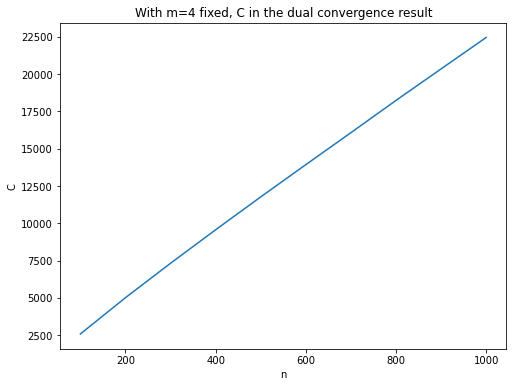

In [100]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()

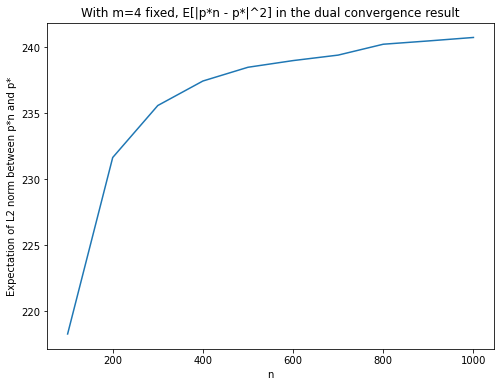

In [101]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()

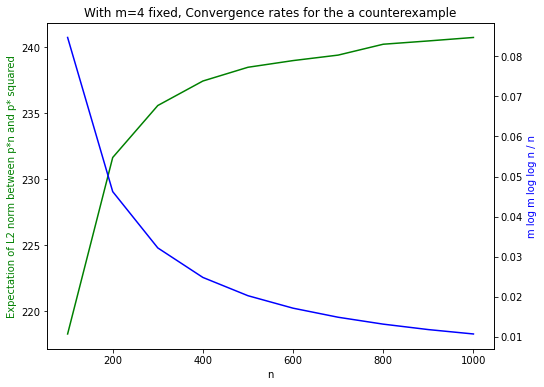

In [102]:
fig, ax1 = plt.subplots(figsize=(8,6))


ax2 = ax1.twinx()

x = list(n_to_diffs.keys())
y1 = list(n_to_mean_diffs.values())
y2 = [m*np.log(m)*np.log(np.log(n))/n for n in x]

ax1.plot(x, y1, 'g-', label="Expectation of L2 norm between p*n and p* squared")
ax2.plot(x, y2, 'b-', label='m log m log log n / n')
ax1.set_xlabel("n")
ax1.set_ylabel("Expectation of L2 norm between p*n and p* squared", color='g')
ax2.set_ylabel("m log m log log n / n", color='b')
plt.title("With m=%d fixed, Convergence rates for the a counterexample" % (m))
#plt.legend()

plt.show()